# <center>Machine Learning Model Evaluation for Diabetes Prediction</center>
</br>
</br>

##### Submitted by: 
- Anjana Rao
- Pujesh Pradhan
</br>
</br>

08/16/2022


### Introduction

This capstone project aims to apply machine learning techniques to the diagnosis of diabetes. We will be training several models to evaluate which yields the highest accuracy in diabetes prediction given the following feature set: number of pregnancies, glucose levels, blood pressure, insulin, BMI, diabetes pedigree function results, and age. 

This project comprises of data exploration, model learning and model evaluation. In the data exploration phase, we aim to understand the landscape of the data primarily paying attention to outcome imbalance and feature correlation. In the model learning and evaluation phase, we train several supervised and unsupervised models. We then determine the accuracy score of each model (number of successful predictions over the number of total predictions). 

The data used in the project is collected from women of at least 21 years of age from Pima Native American descent. While we recognize the limited population scope, we see this as a proof-of-concept that could be scaled to other population groups.

The dataset is sourced from Kaggle: https://www.kaggle.com/datasets/mathchi/diabetes-data-set. 


The list of features that are present in our dataset and its description is as follows: 

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1)




### Libraries 

We leveraged the following libraries for this project. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from IPython.display import Javascript

%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes (3).csv


In [3]:
import io
diabetes_df = pd.read_csv(io.BytesIO(uploaded['diabetes.csv']))

###Fields in Diabetes Data Frame

In [4]:
print(f"There are {diabetes_df.shape[0]} number of data points and {diabetes_df.shape[1]} number of columns. ")

There are 768 number of data points and 9 number of columns. 


In [5]:
diabetes_df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [6]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


###Data Cleaning 

In [7]:
print("Checking for null values in the dataset.")

diabetes_df.isnull().sum()

Checking for null values in the dataset.


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
print("Checking for counts of data points with value = 0 in each field:")

for field in diabetes_df:
  print(field.ljust(25, " "), '-', diabetes_df[diabetes_df[field]==0][field].count())

Checking for counts of data points with value = 0 in each field:
Pregnancies               - 111
Glucose                   - 5
BloodPressure             - 35
SkinThickness             - 227
Insulin                   - 374
BMI                       - 11
DiabetesPedigreeFunction  - 0
Age                       - 0
Outcome                   - 500


From the above output, all of the columns besides DiabetesPedigreeFunction and Age have 0 values. 

As per the definition above, the value in 'Pregnancies' column determines the number of times a woman became pregnant. Thus, 0 here is a legitimate data point. 

Other columns containing 0 as a field should be cleaned as they represent an invalid amount.  

This data set does not explicitly provide instructions on how to handle invalid fields. We decided to derive the mean of each column's non-zero values and replaced the invalid fields with the mean. This approach preserves the number of data points our models have to train off of. 

In [9]:
print("Describing statistics of our dataset before transfromation: ")
diabetes_df.describe().T

Describing statistics of our dataset before transfromation: 


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [10]:
for field_name in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
  mean_value = diabetes_df[diabetes_df[field_name] != 0][field_name].mean()
  diabetes_df[field_name].replace(0, mean_value, inplace=True)

In [11]:
print("Describing statistics of our dataset after transfromation: ")
diabetes_df.describe().T

Describing statistics of our dataset after transfromation: 


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.000000,6.000000,17.00
Glucose,768.0,121.686763,30.435949,44.000,99.75000,117.000000,140.250000,199.00
BloodPressure,768.0,72.405184,12.096346,24.000,64.00000,72.202592,80.000000,122.00
SkinThickness,768.0,29.153420,8.790942,7.000,25.00000,29.153420,32.000000,99.00
Insulin,768.0,155.548223,85.021108,14.000,121.50000,155.548223,155.548223,846.00
BMI,768.0,32.457464,6.875151,18.200,27.50000,32.400000,36.600000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.372500,0.626250,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.000000,41.000000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.000000,1.000000,1.00


###Data Exploration 

###### Outcome 0 vs Outcome 1


This indicates how balanced the data is. Data that has a significantly uneven distribution of target data could result in poor accuracy scores in our models. 

In [12]:
sns.set(rc = {'figure.figsize':(7,7)})

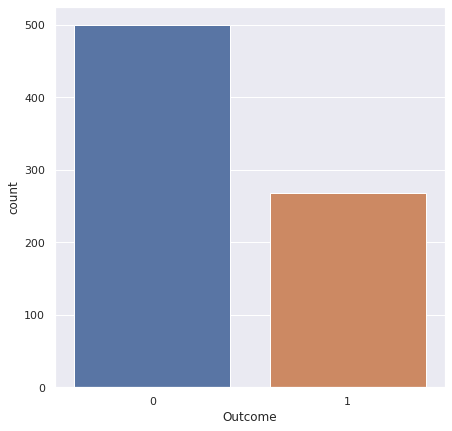

In [13]:
sns.countplot(x='Outcome', data=diabetes_df)

In [14]:
no_diabetes = diabetes_df['Outcome'].value_counts()[0]
diabetes = diabetes_df['Outcome'].value_counts()[1]

print('The number of participants in the study without diabetes is', no_diabetes)
print('The number of participants in the study with diabetes is', diabetes)

The number of participants in the study without diabetes is 500
The number of participants in the study with diabetes is 268


The number of data points for 0 (without diabetes) is almost double of the data point for 1 (with diabetes) 

While there is a discrepancy between outcome counts, a 1:2 ratio is generally acceptable as balanced data. 

##### BMI vs Skin Thickness 

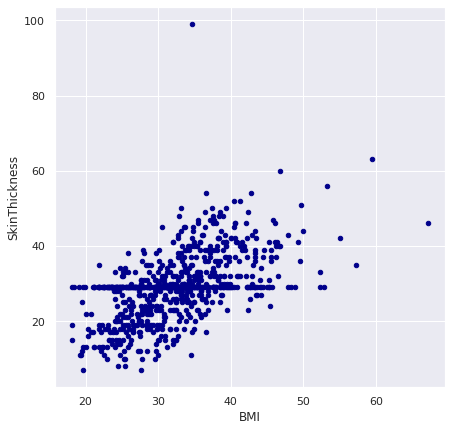

In [15]:
ax1 = diabetes_df.plot.scatter(x='BMI', y='SkinThickness',c='DarkBlue')

The visualization above signals that there is a positive correlation between BMI and skin thickness illustrating that the greater the skin thickness, the higher a particapant's BMI. 

##### Outcome vs Glucose levels 

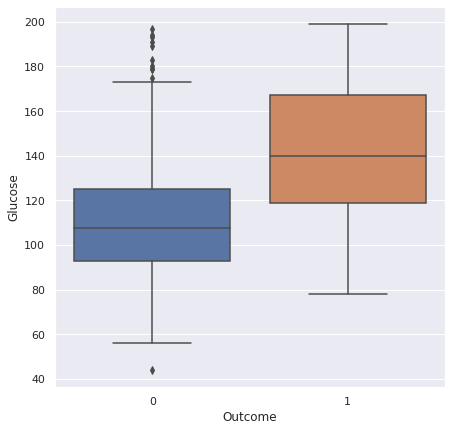

In [16]:
sns.boxplot(x="Outcome", y="Glucose", data=diabetes_df);

We observe that the average glucose level, approximately 140, is higher than the average glucose level without diabetes, approximately 115. Glucose levels under 140 mg/dL are considered to be a healthy range (reference: [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451#:~:text=A%20blood%20sugar%20level%20less,hours%20means%20you%20have%20diabetes.))

##### Outcome vs Age

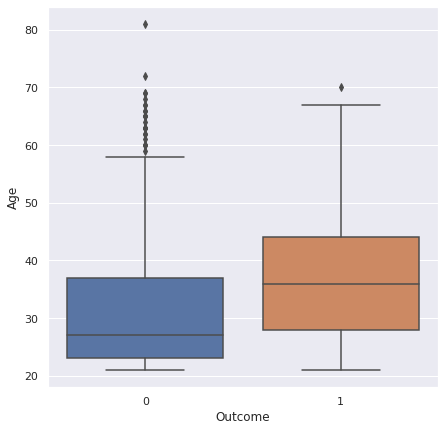

In [17]:
sns.boxplot(x="Outcome", y="Age", data=diabetes_df);

Particapants with diabetes tend to be slightly older on average (~35) and their ages tend to range between roughly 28 to 44.

##### Outcome vs BMI

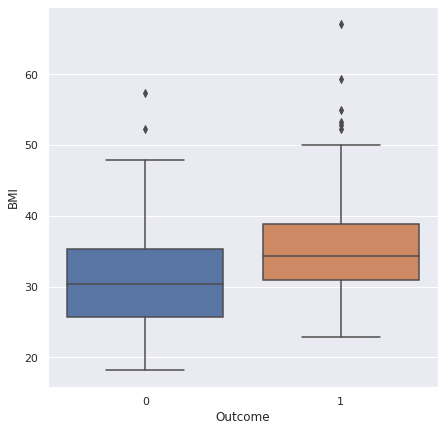

In [18]:
sns.boxplot(x="Outcome", y="BMI", data=diabetes_df);

Participants with diabetes on average tend to have a slightly higher BMI. 

##### Age vs Pregnancy Count

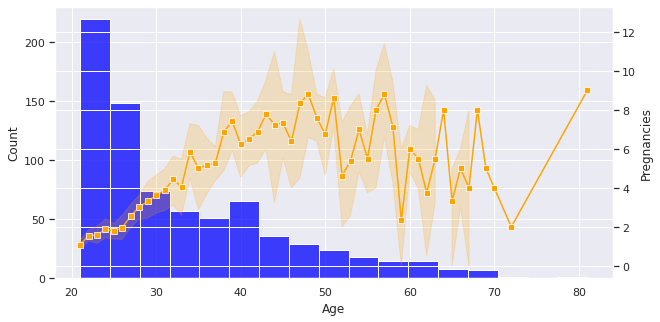

In [19]:
fig=plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

sns.histplot(x='Age', data=diabetes_df, color='blue', ax=ax1)
sns.lineplot(x='Age', y='Pregnancies', data=diabetes_df, marker='s', color='orange', ax=ax2)

plt.show()

The above graph shows us that the dataset contains data mostly about younger women who are below 30 years of age. The number of pregnancies in this age range is lower compared to participants in their 30s and beyond. 

##### Age vs Glucose and Age vs Blood Pressure

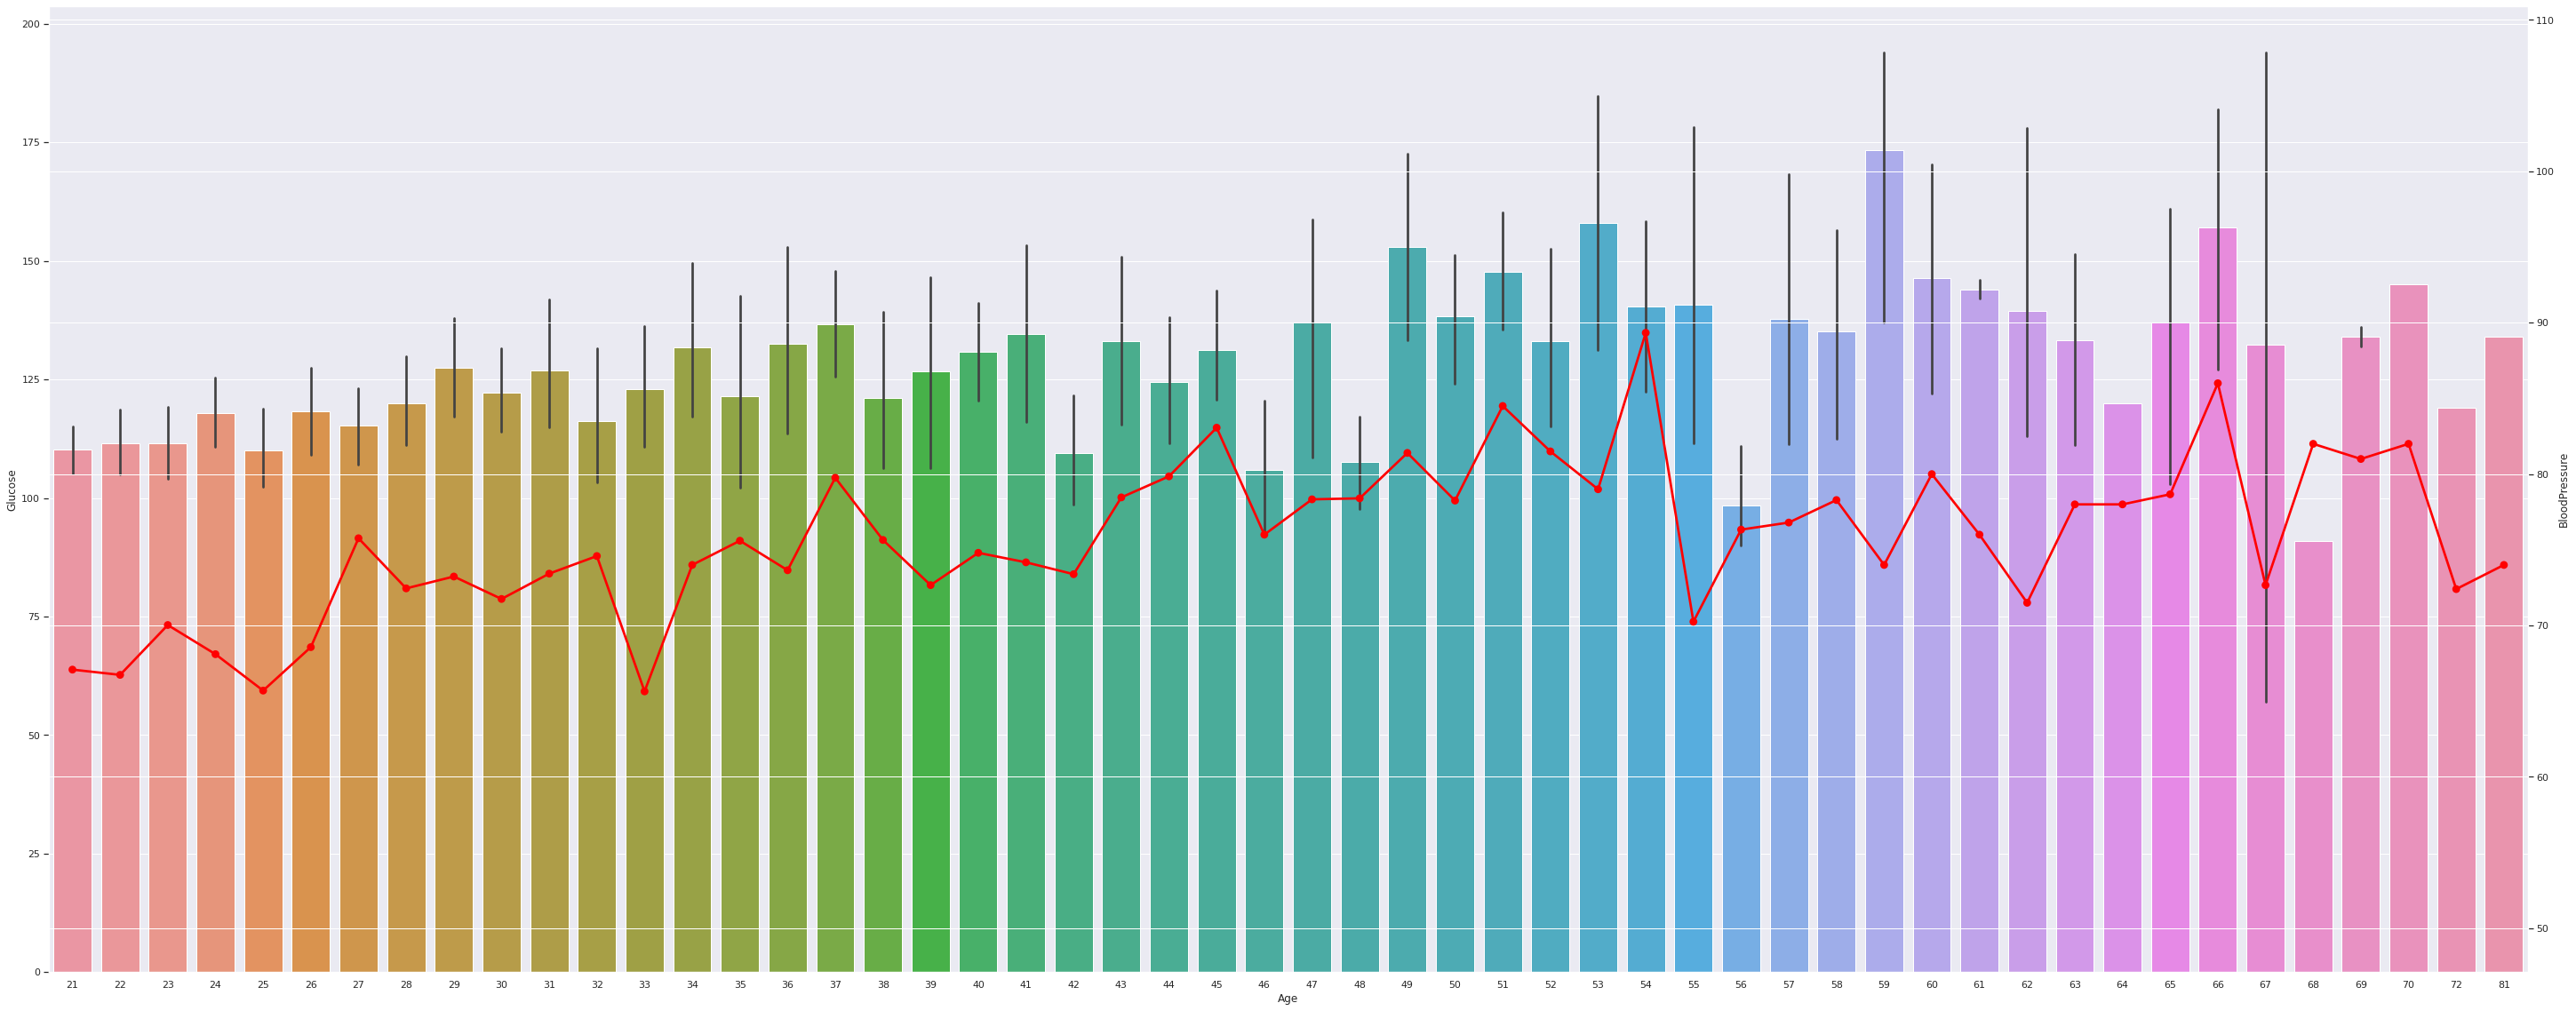

In [20]:
fig=plt.figure(figsize=(50,20))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

sns.barplot(x='Age', y='Glucose', data=diabetes_df, ax=ax1)
sns.pointplot(x='Age', y='BloodPressure', data=diabetes_df, color='red', errwidth=0, marker='s', ax=ax2)

plt.show()

From the above visualization we can see that the Blood Pressure value for all the female looks to be in a good range. While, the Glucose value looks normal in most of the cases since the values are below 155 mg/dL based on [the document by Mayo Clinic.](https://www.mayoclinic.org/tests-procedures/glucose-tolerance-test/about/pac-20394296), Glucose in some women above age 47 seems to be high. 

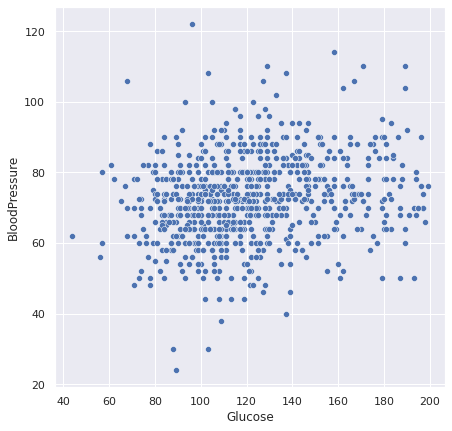

In [21]:
sns.scatterplot(x='Glucose', y='BloodPressure', data=diabetes_df)

The scatter plot shows that there is no correlation between Glucose and Blood Pressure. Increase in Glucose does not have any impact on the Blood Pressure level or vice-versa. 

##### Correlation Matrix

(9.5, -0.5)

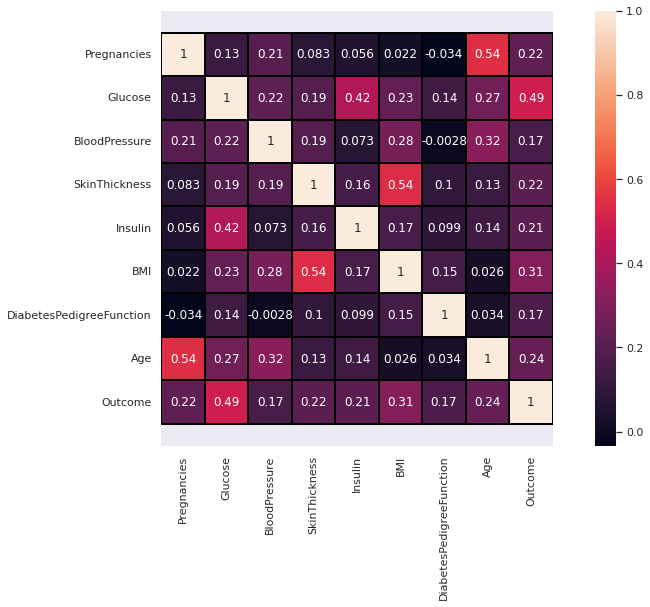

In [22]:
matrix = np.triu(diabetes_df.corr())

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(diabetes_df.corr(), annot = True, square=True, \
            linewidths=1, linecolor='black') 

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<IPython.core.display.Javascript object>

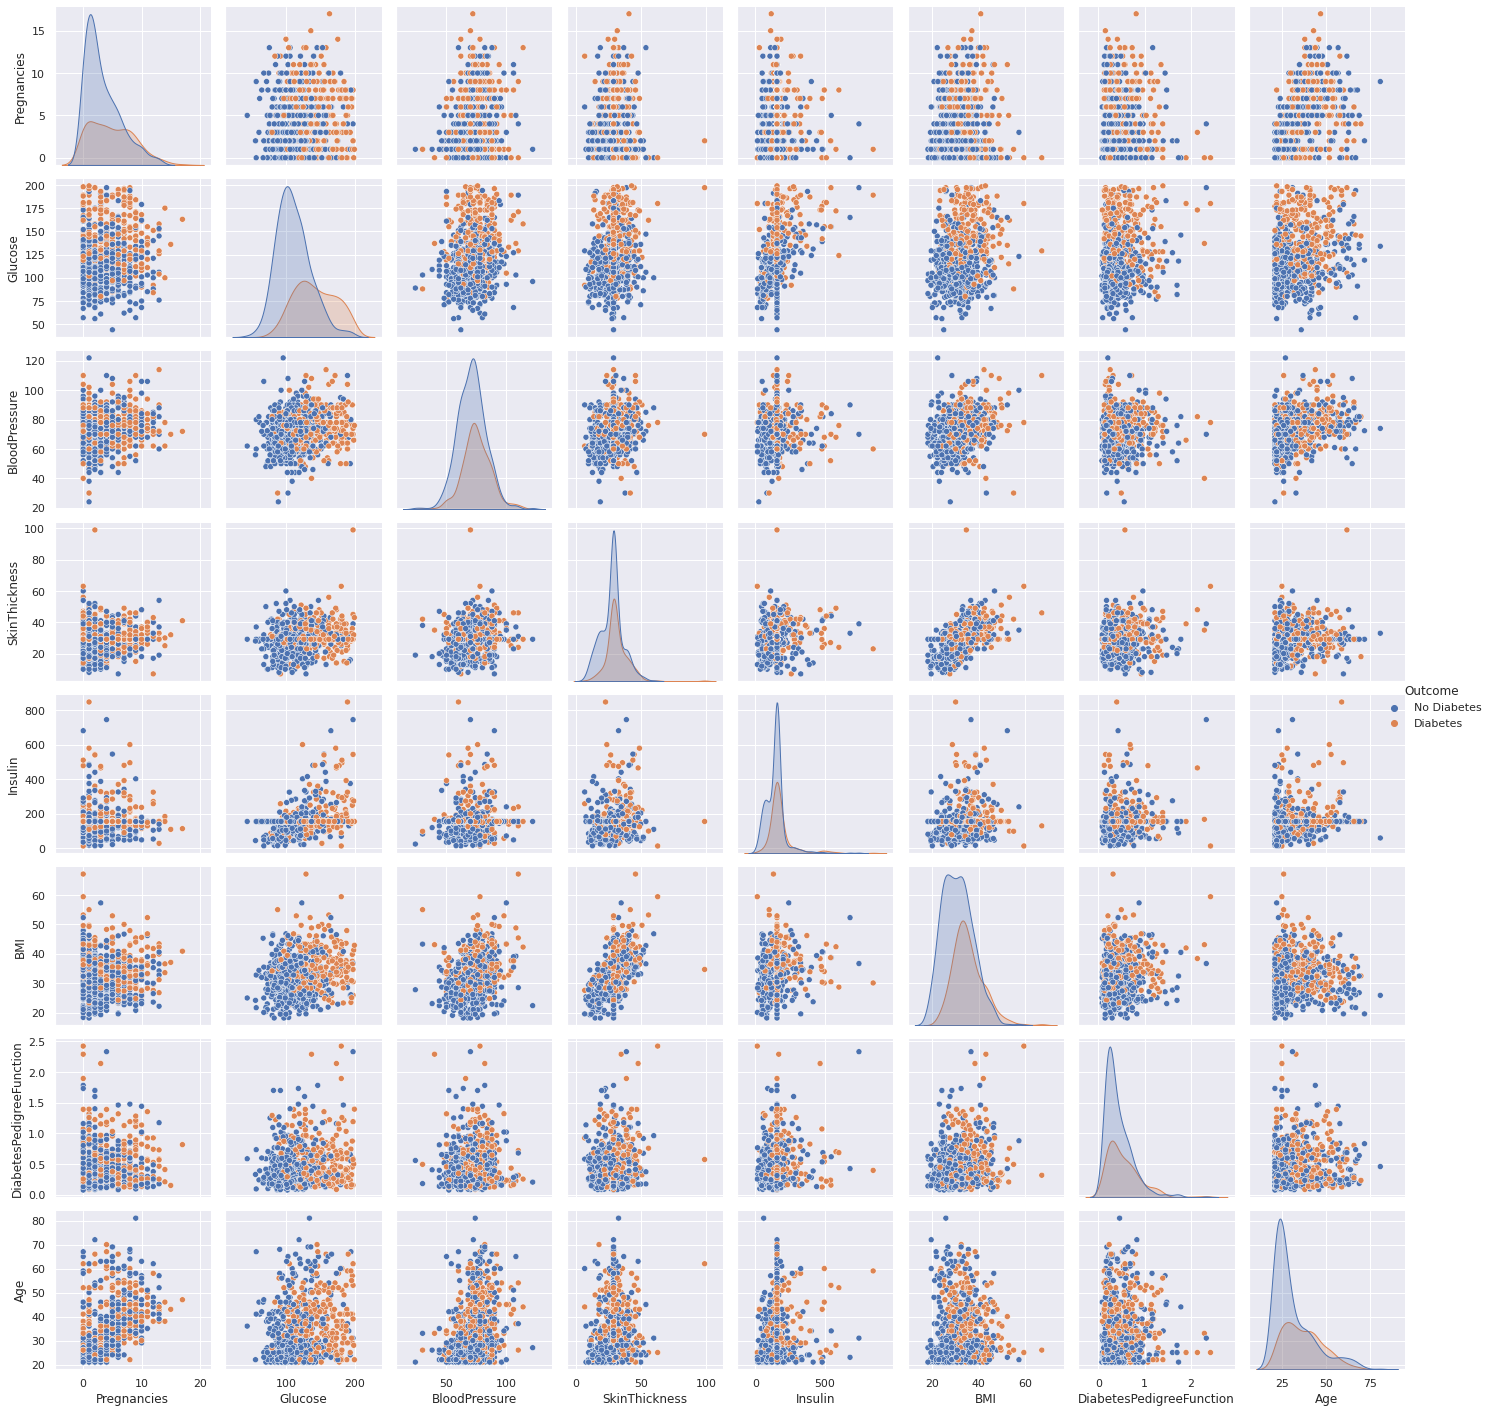

In [23]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

_sns_pairplot_data = sns.pairplot(diabetes_df, hue='Outcome')

new_labels = ['No Diabetes', 'Diabetes']
for t, l in zip(_sns_pairplot_data._legend.texts, new_labels): 
    t.set_text(l)

### Data Preperation 

Since our data has a high variation among the fields, we are scaling the data such that the mean is 0 and the standard deviation is 1. Scaling is required as this prevents fields with a higher value from being overemphasized in model training and prediction. 

In [24]:
scaler = StandardScaler() # creating an instance of Standard Scaler

In [25]:
diabetes_independent = scaler.fit_transform(
    diabetes_df[['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
)

diabetes_target = diabetes_df[['Outcome']]

In [26]:
x_train, x_test, y_train, y_test = train_test_split(diabetes_independent, diabetes_target, test_size=0.2, random_state=10)

### Principal Component Analysis

Since we have 8 feature variables, we will create PCA with 2 - 5 components. After generating the components, we deterine the the number of components that captures the highest variance (90% of the dataset). 

In [27]:
for n_components in range(2,7):
    print(f"Considering {n_components} components for the PCA!")
    pca_comp = PCA(n_components=n_components, random_state=10)
    pca_comp.fit_transform(diabetes_independent)
    print(f"The explained variance ratio for PCA with {n_components} components are: {pca_comp.explained_variance_ratio_}")
    print(f"The PCA with {n_components} components explains: {round(pca_comp.explained_variance_ratio_.sum() * 100, 2)}% of the dataset")
    print("\n")

Considering 2 components for the PCA!
The explained variance ratio for PCA with 2 components are: [0.28750131 0.18411087]
The PCA with 2 components explains: 47.16% of the dataset


Considering 3 components for the PCA!
The explained variance ratio for PCA with 3 components are: [0.28750131 0.18411087 0.14102225]
The PCA with 3 components explains: 61.26% of the dataset


Considering 4 components for the PCA!
The explained variance ratio for PCA with 4 components are: [0.28750131 0.18411087 0.14102225 0.11594187]
The PCA with 4 components explains: 72.86% of the dataset


Considering 5 components for the PCA!
The explained variance ratio for PCA with 5 components are: [0.28750131 0.18411087 0.14102225 0.11594187 0.09605539]
The PCA with 5 components explains: 82.46% of the dataset


Considering 6 components for the PCA!
The explained variance ratio for PCA with 6 components are: [0.28750131 0.18411087 0.14102225 0.11594187 0.09605539 0.06871256]
The PCA with 6 components explains: 89.3

When considering 6 components, we can see that it determines/explains the dataset by ~89%. We will develop a graph for PCA with components 6 as it almost meets our threshold of 90%. 

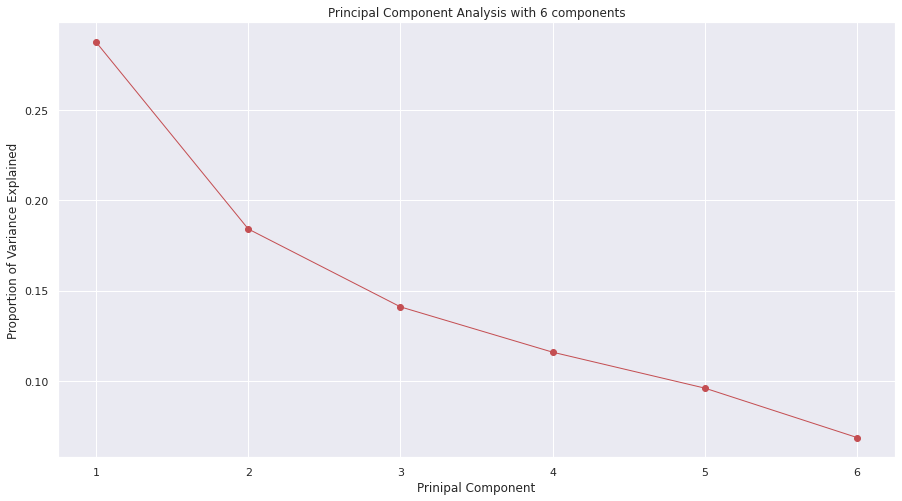

In [28]:
n_components = 6
pca_comp = PCA(n_components=n_components, random_state=10)
principal_comp = pca_comp.fit_transform(diabetes_independent)

pca_df = pd.DataFrame(principal_comp, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])

pc_values = np.arange(n_components) + 1

plt.plot(pc_values, pca_comp.explained_variance_ratio_, 'ro-', linewidth=1)
plt.title('Principal Component Analysis with 6 components')
plt.xlabel('Prinipal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

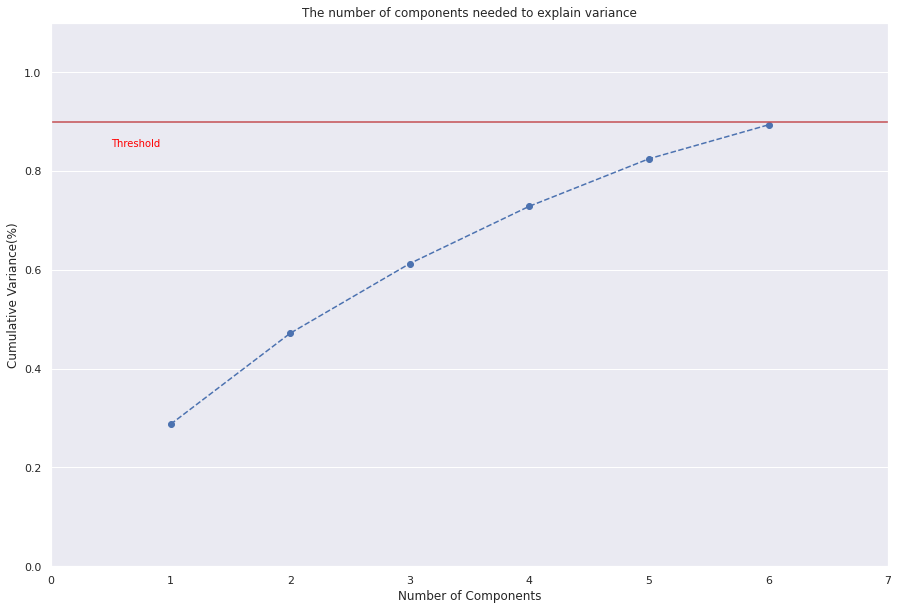

In [29]:
plt.rcParams["figure.figsize"] = (15,10)

fig, ax = plt.subplots()
xi = np.arange(1,7, step=1)
yi = np.cumsum(pca_comp.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 8, step=1))
plt.ylabel('Cumulative Variance(%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.text(0.5, 0.85, 'Threshold', color='red', fontsize=10)

ax.grid(axis='x')
plt.show()

### Models 

In the following section, we demonstrate outcome prediction with the following learning models: Logistic Regression, KNN, SVM, Decision Tree, and Random Forest. For each model, we compute the accuracy score to determine the most optimal model for diabetes prediction. 

#### Logistic Regression

We first perform logistic regression without regularization. 

In [30]:
logistic_reg = LogisticRegression()

logistic_reg.fit(x_train, y_train.values.ravel())

logistic_reg_predict_test = logistic_reg.predict(x_test)

print(f"The accuracy score for the training set is: {round(logistic_reg.score(x_train, y_train) * 100, 2)}%")
print(f"The accuracy score for the test set is: {round(logistic_reg.score(x_test, y_test) * 100, 2)}%")

The accuracy score for the training set is: 77.36%
The accuracy score for the test set is: 74.03%


We then perform Logistic regression with an L1 penalty. 

In [31]:
logistic_reg = LogisticRegression(penalty='l1', solver='liblinear')

logistic_reg.fit(x_train, y_train.values.ravel())

logistic_reg_predict_test = logistic_reg.predict(x_test)

print(f"The accuracy score for the training set is: {round(logistic_reg.score(x_train, y_train) * 100, 2)}%")
print(f"The accuracy score for the test set is: {round(logistic_reg.score(x_test, y_test) * 100, 2)}%")

The accuracy score for the training set is: 77.52%
The accuracy score for the test set is: 74.03%


Regularization is generally a solution for overfitting. We can see that there was no significant change in accuracy scores for the training set (accuracy score with regularization is 77.52% and without is 77.36%). The accuracy score for our test set with and withought regualarization is exactly the same- 74.03%. The lack of significant change in accuracy shows that our model does not have high bias and is not overfitting. 

To further improve accuracy of our logistic regression model, we train the model with the data frame generated from PCA. 

In [32]:
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(pca_df, diabetes_target, test_size = 0.2, random_state=10)


logistic_reg_pca = LogisticRegression(penalty='l1', solver='liblinear')
logistic_reg_pca.fit(x_train_log, y_train_log.values.ravel())

logistic_reg_predict_test_pca = logistic_reg_pca.predict(x_test_log)

print(f"The accuracy score for the training set is: {round(logistic_reg_pca .score(x_train_log, y_train_log) * 100, 2)}%")
print(f"The accuracy score for the test set is: {round(logistic_reg_pca .score(x_test_log, y_test_log) * 100, 2)}%")

The accuracy score for the training set is: 77.52%
The accuracy score for the test set is: 70.78%


By training the logistic regression model with our calculated principle components, we noticed a steep decline in accuracy from 74.03% to 70.78%. We can see here that training our model with principle components is diminishing accuracy as it is most likely over-simplifying our train data. 

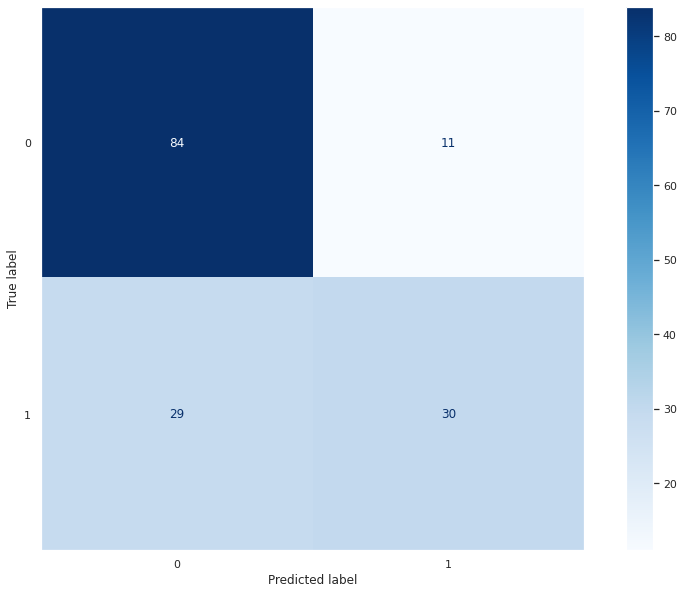

In [33]:
ConfusionMatrixDisplay.from_estimator(logistic_reg, x_test, y_test, cmap="Blues")  
plt.grid(False)
plt.show()  

In [34]:
logit_roc_auc = roc_auc_score(y_test, logistic_reg_predict_test)
print("Logistic AUC = %0.2f" %logit_roc_auc)
print(classification_report(y_test, logistic_reg_predict_test))

Logistic AUC = 0.70
              precision    recall  f1-score   support

           0       0.74      0.88      0.81        95
           1       0.73      0.51      0.60        59

    accuracy                           0.74       154
   macro avg       0.74      0.70      0.70       154
weighted avg       0.74      0.74      0.73       154



Out of the three variations of Logistic Regression (no regularization, regularization, training with principle components), the highest accuracy appears to be 74.03%. 

#### KNN 

In [35]:
"""
We are fitting models for different values of k. We are then finding accuracy for each model 
and storing it in scores_list.
"""
k_range = range(1, 20)
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, np.ravel(y_train))
    y_pred_knn = knn.predict(x_test)
    scores_list.append(accuracy_score(y_test, y_pred_knn))

Accuracy score List for KNN between 1 through 20: [0.7012987012987013, 0.7272727272727273, 0.7142857142857143, 0.7337662337662337, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7077922077922078, 0.7272727272727273, 0.7077922077922078, 0.7077922077922078, 0.6688311688311688, 0.7142857142857143, 0.7077922077922078, 0.7142857142857143, 0.7207792207792207, 0.7012987012987013, 0.7077922077922078, 0.7077922077922078]


Text(0, 0.5, 'Test Accuracy')

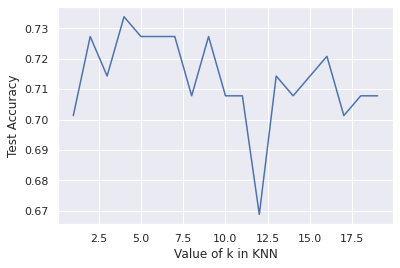

In [36]:
# We are plotting accuracy for different values of k
%matplotlib inline
import matplotlib.pyplot as plt

print("Accuracy score List for KNN between 1 through 20:", scores_list)
plt.plot(k_range, scores_list)
plt.xlabel("Value of k in KNN")
plt.ylabel("Test Accuracy")

In the chart displayed above, we can see that k = 4 provides the the highest accuracy. Given this information, we built a model classifier for K-nearest neighbors where k = 4. 

The accuracy score for KNN where k=4 is 0.7337662337662337


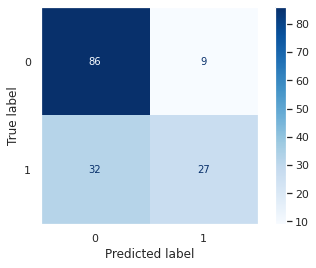

In [37]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(x_train, np.ravel(y_train))

y_pred_knn = knn.predict(x_test)
print("The accuracy score for KNN where k=4 is", accuracy_score(y_test, y_pred_knn))

ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, cmap="Blues")  
plt.grid(False)
plt.show()  

#### Decision Tree

In [38]:
decision_tree = DecisionTreeClassifier(random_state=10)

decision_tree.fit(x_train, y_train)

decision_tree_pred_test = decision_tree.predict(x_test)

print(f"The accuracy score for the training set is: {decision_tree.score(x_train, y_train) * 100}%")
print(f"The accuracy score for the test set is: {round(decision_tree.score(x_test, y_test) * 100, 2)}%")

The accuracy score for the training set is: 100.0%
The accuracy score for the test set is: 72.73%


There is a gap of ~28% between the accuracy score for the training set as well as test set. This looks to be the case of our dataset being overfitting. 

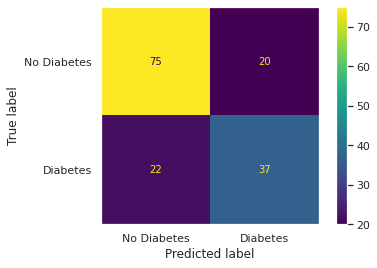

In [39]:
ConfusionMatrixDisplay.from_estimator(decision_tree, x_test, y_test, display_labels=['No Diabetes', 'Diabetes'])
plt.grid(False)

In [40]:
print("Classification Report: ")
print(classification_report(y_test, decision_tree_pred_test))

Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        95
           1       0.65      0.63      0.64        59

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



From the above classification report as well as confusion matrix, the data are not being well predicted. The total of 42 data points are predicted falsely out of 154 data points. This has the accuracy of 73%. Since, the data point for patients tested positive for Diabetes is less, the precision and the recall value on predicting this outcome is lower than predicting patient having No Diabetes. 

Using GridSearchCV we can find hyperparameters that are more suitable for Decision Tree model and find if the accuracy score could be better.

In [41]:
decision_tree_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'],
    'max_depth': [2,4,6,8,10,15,17,20,None],
    'min_samples_split': [2,3,4],
    'random_state': [10]
}

gridsearch_cv = GridSearchCV(decision_tree, param_grid=decision_tree_parameters, cv=3, verbose=True, n_jobs=5)

clf = gridsearch_cv.fit(x_train, y_train) 

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [42]:
print(f"The best hyperparameters to predict our outcome using Decision Tree to get accuracy score of {round(clf.best_score_ * 100, 2)}% are: \n")
print(f"{clf.best_params_}")

The best hyperparameters to predict our outcome using Decision Tree to get accuracy score of 74.28% are: 

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 4, 'random_state': 10, 'splitter': 'random'}


Using above hyper parameters to fit our data and make predictions on our outcome

In [43]:
decision_tree_param = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=4, splitter='random', random_state=10)
decision_tree_param.fit(x_train, y_train) 

decision_tree_pred_param = decision_tree_param.predict(x_test)

print(f"The accuracy score for the training set is: {decision_tree_param.score(x_train, y_train) * 100}%")
print(f"The accuracy score for the test set is: {round(decision_tree_param.score(x_test, y_test) * 100, 2)}%")

The accuracy score for the training set is: 76.54723127035831%
The accuracy score for the test set is: 70.13%


After using the hyperparameters from the GridSearch, we can see that the accuracy score of test set did not improve. However, the accuracy score for the training set decreased by ~25%. This could signal that our model is not overfitting the data anymore. 

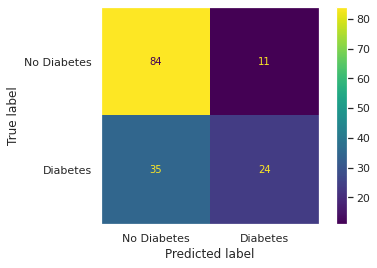

In [44]:
ConfusionMatrixDisplay.from_estimator(decision_tree_param, x_test, y_test, display_labels=['No Diabetes', 'Diabetes'])
plt.grid(False)

In [45]:
print("Classification Report: ")
print(classification_report(y_test, decision_tree_pred_param))

Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        95
           1       0.69      0.41      0.51        59

    accuracy                           0.70       154
   macro avg       0.70      0.65      0.65       154
weighted avg       0.70      0.70      0.68       154



From the above classification report and confusion matrix, not much imporvement could be seen in terms of classification. 

Out of the eight feature, determining the features that are highly important in predicting the outcome


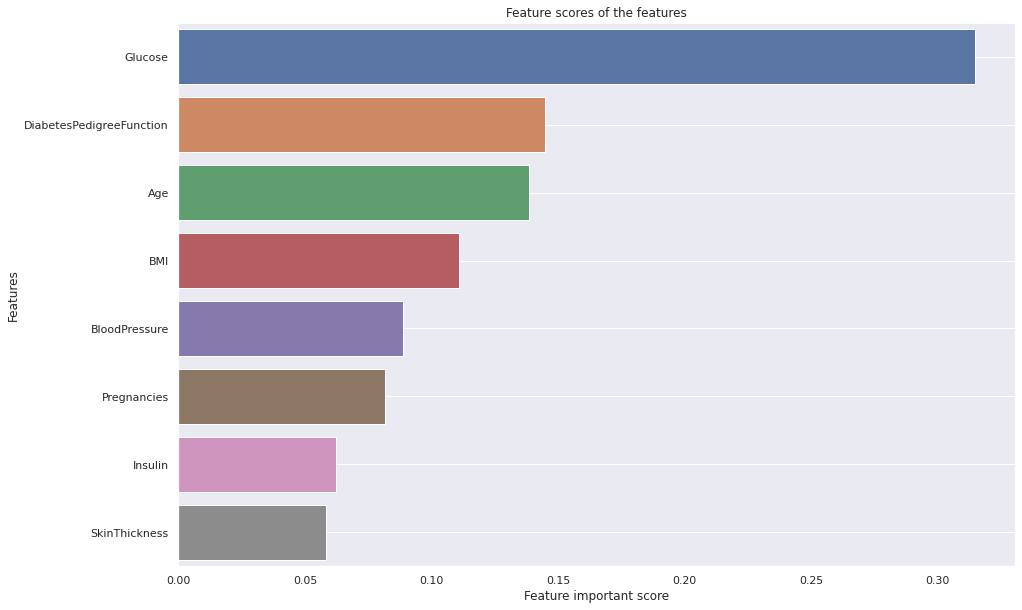

In [46]:
print("Out of the eight feature, determining the features that are highly important in predicting the outcome")

diabetes_var = diabetes_df[['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

feature_score = pd.Series(decision_tree.feature_importances_, index=diabetes_var.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=feature_score, y=feature_score.index, data=diabetes_var.T)
ax.set_title("Feature scores of the features")
ax.set_yticklabels(feature_score.index)
ax.set_xlabel("Feature important score")
ax.set_ylabel("Features")
ax.grid()
plt.show()

From the feature importance graph, Glucose tend to look the most important feature in determining whether the person has Diabetes or No Diabetes. Followed by other features are DiabetesPedigreeFunction, Age and BMI. 

Using these four fields in our model to predict along with the above hyperparameters from the GridSearch. These four columns cover about 70% of the importance of the features.

In [47]:
pred_df = diabetes_df[['Glucose', 'DiabetesPedigreeFunction', 'Age', 'BMI']]
targ_df = diabetes_df[['Outcome']]

x_train_sel, x_test_sel, y_train_sel, y_test_sel = train_test_split(pred_df, targ_df, test_size=0.2, random_state=10)

tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=4, splitter='random', random_state=10)

tree.fit(x_train_sel, y_train_sel)

decs_tree_pred = tree.predict(x_test_sel)

print(f"The accuracy score for the training set is: {tree.score(x_train_sel, y_train_sel) * 100}%")
print(f"The accuracy score for the test set is: {round(tree.score(x_test_sel, y_test_sel) * 100, 2)}%")

The accuracy score for the training set is: 77.68729641693811%
The accuracy score for the test set is: 74.68%


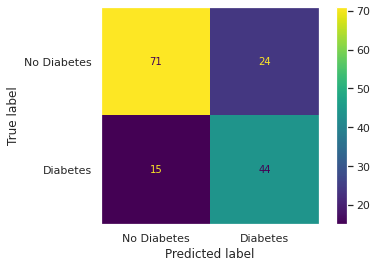

In [48]:
ConfusionMatrixDisplay.from_estimator(tree, x_test_sel, y_test_sel, display_labels=['No Diabetes', 'Diabetes'])
plt.grid(False)

In [49]:
print("Classification Report: ")
print(classification_report(y_test, decs_tree_pred))

Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.75      0.78        95
           1       0.65      0.75      0.69        59

    accuracy                           0.75       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.76      0.75      0.75       154



With selected important features, there has been a slight improvement in the accuracy score by ~4%. Considering only the important features could help in predicting our outcome slightly better than considering all of the features. 

Using PCA components to compare if the accuracy score is better than previous. 

In [50]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(pca_df, diabetes_target, test_size=0.2, random_state=10)

d_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=4, splitter='random', random_state=10)

d_tree.fit(x_train_pca, y_train_pca)

d_tree_pred = d_tree.predict(x_test_pca)

print(f"The accuracy score for the training set is: {d_tree.score(x_train_pca, y_train_pca) * 100}%")
print(f"The accuracy score for the test set is: {round(d_tree.score(x_test_pca, y_test_pca) * 100, 2)}%")

The accuracy score for the training set is: 75.2442996742671%
The accuracy score for the test set is: 68.18%


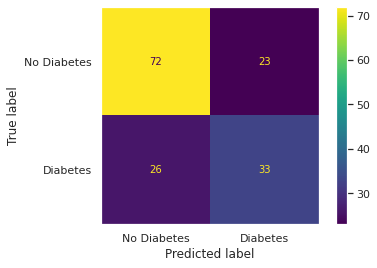

In [51]:
ConfusionMatrixDisplay.from_estimator(d_tree, x_test_pca, y_test_pca, display_labels=['No Diabetes', 'Diabetes'])
plt.grid(False)

In [52]:
print("Classification Report: ")
print(classification_report(y_test_pca, d_tree_pred))

Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.76      0.75        95
           1       0.59      0.56      0.57        59

    accuracy                           0.68       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.68      0.68      0.68       154



Using PCA components did not give us better than when selecting the important features we obtained from the important features function. The accuracy score is bit lower by ~10 points due to which, the PCA components will not be considered for Decision Tree as well as Random Forest below. 

#### Random Forest

Using Random Forest, will help us to create different variation of trees for above dataset. The best model can be picked from all of the variations of the trees. Using different estimators for the RandomForestClassifier will help determine the maximum number of trees that can be created until the best score is obtained. 

In [53]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=10)
random_forest.fit(x_train_sel, y_train_sel.values.ravel())

random_forest_predict = random_forest.predict(x_test_sel)

print(f"The accuracy score for the training set is: {round(random_forest.score(x_train_sel, y_train_sel.values.ravel()) * 100, 2)}%")
print(f"The accuracy score for the test set is: {round(random_forest.score(x_test_sel, y_test_sel.values.ravel()) * 100, 2)}%")

The accuracy score for the training set is: 100.0%
The accuracy score for the test set is: 77.27%


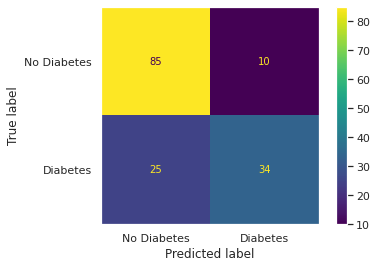

In [54]:
ConfusionMatrixDisplay.from_estimator(random_forest, x_test_sel, y_test_sel, display_labels=['No Diabetes', 'Diabetes'])
plt.grid(False)

In [55]:
print("Classification Report: ")
print(classification_report(y_test, random_forest_predict))

Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        95
           1       0.77      0.58      0.66        59

    accuracy                           0.77       154
   macro avg       0.77      0.74      0.74       154
weighted avg       0.77      0.77      0.76       154



The accuracy score for the training set tends to be 100% while the score for the test set is only 77.27%. By providing the estimator as 100, we do get better accuracy score for the dataset compared to the score we obtained from the test set. 

As the accuracy score went up, we can also see that the number of data points falsely preicted as lowered by a little as well. 

We can use GridSearchCV to determine the best parameters for Random Forest. 

In [ ]:
random_forest_parameters = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2,4,6,8,None],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [10]
}

gridsearch_cv = GridSearchCV(random_forest, param_grid=random_forest_parameters, cv=3, verbose=True, n_jobs=5)

clf = gridsearch_cv.fit(x_train_sel, y_train_sel.values.ravel()) 

Fitting 3 folds for each of 210 candidates, totalling 630 fits


In [ ]:
print(f"The best hyperparameters to predict our outcome using Decision Tree to get accuracy score of {round(clf.best_score_ * 100, 2)}% are: \n")
print(f"{clf.best_params_}")

Creating RandomForestClassifier model with the above hyperparameters.

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=150, criterion='entropy', max_depth=4, max_features='sqrt', random_state=10)
random_forest_model.fit(x_train_sel, y_train_sel.values.ravel())

random_forest_predict_1 = random_forest.predict(x_test_sel)

print(f"The accuracy score for the training set is: {round(random_forest_model.score(x_train_sel, y_train_sel.values.ravel()) * 100, 2)}%")
print(f"The accuracy score for the test set is: {round(random_forest_model.score(x_test_sel, y_test_sel.values.ravel()) * 100, 2)}%")

In [ ]:
ConfusionMatrixDisplay.from_estimator(random_forest_model, x_test_sel, y_test_sel, display_labels=['No Diabetes', 'Diabetes'])
plt.grid(False)

In [ ]:
print("Classification Report: ")
print(classification_report(y_test, random_forest_predict_1))

With the RandomForest and the hyperparameters obtained from the GridSearch, we did not see much improvement on the accuracy score. The number of data points incorrectly predicted is slightly higher too. 

### Conclusion

We've printed the accuracy scores below for comparison: 

|Model|Parameters|Accuracy Score(%)|
|-----|:---------|:----------------|
|Logistic Regression|{penalty='l1', solver='liblinear'}|74|
|KNN|{k=4}|73|
|Decision Tree|{criterion='entropy', max_depth=4, min_samples_split=4, splitter='random'}|75|
|Random Forest|{n_estimators=150, criterion='entropy', max_depth=4, max_features='sqrt'}|77|

Based on accuracy scores across all the models trained for this experiment, we can see that Random Forest yields the highest accuracy for diabetes prediction at 77%. While we believe that this is sufficient evidence to prove that Random Forest Classifier is a wise-choice for the selected data set, we see further opportunity for model enhancement. 

Accuracy of ML models hinge on having both a sizable amount of data to train against. The data set that we chose was fairly limited with only 768 rows. Additional data would improve the accuracy and viability of our models as diagnostic tools. The data present had several hundred invalid values that needed to be adjusted, this could have caused further diminishment in accuracy. 

We also consider that the features in the data set are fairly limited. With only 8 features to train against, there is less opportunity for feature engineering in order to extract the strongest outcome predictors. Given our lack of domain experience in this field, we acknowledge that we may be missing other vital features that could impact the prediction of diabetes. 

Overall, we were able to predict diabetes within women of Pima Native descent with 77% accuracy. With additional steps taken to enhance the accuracy of our models, this project serves as a proof-of-concept for applying machine learning to diabetes detection that can scale across a broader population.  
